In [1]:
import numpy as np
import pandas as pd
#from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.interpolate import griddata
import matplotlib.animation as animation

In [2]:
#plt.rcParams["figure.figsize"] = (15,5)

In [3]:
# %matplotlib inline

In [4]:
img=mpimg.imread('background_face.png')

In [5]:
data = np.array([
    [0,0,0,0,0,0],
    [0,0,0,2,0,0],
    [0,0,3,3,0,0],
    [0,0,0,0,0,0]])

In [6]:
# fig, ax = plt.subplots()
# ax.imshow(img, extent=[5, 0, 4, 0])
# ax.imshow(data, interpolation='gaussian', alpha=0.6, cmap='inferno')

In [7]:
data2 = np.array([
    [0,0,0,0,0,2],
    [0,0,0,1,3,0],
    [0,0,0,1,0,0],
    [0,0,0,0,0,0]])

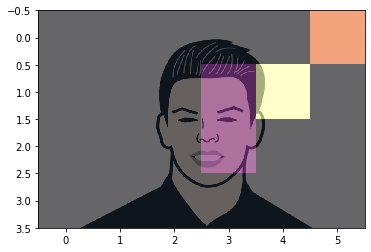

In [8]:
fig, ax = plt.subplots()
ax.imshow(img, extent=[5, 0, 4, 0])
ax.imshow(data2, alpha=0.6, cmap='inferno')

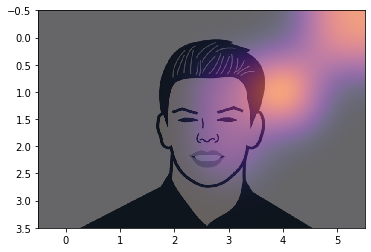

In [9]:
fig, ax = plt.subplots()
ax.imshow(img, extent=[5, 0, 4, 0])
ax.imshow(data2, interpolation='gaussian', alpha=0.6, cmap='inferno')

In [10]:
#plt.figure(figsize=(20,10))

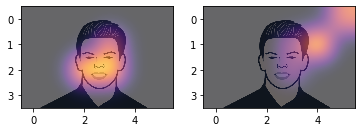

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, extent=[5, 0, 4, 0])
ax1.imshow(data, interpolation='gaussian', alpha=0.6, cmap='inferno')
ax2.imshow(img, extent=[5, 0, 4, 0])
ax2.imshow(data2, interpolation='gaussian', alpha=0.6, cmap='inferno')

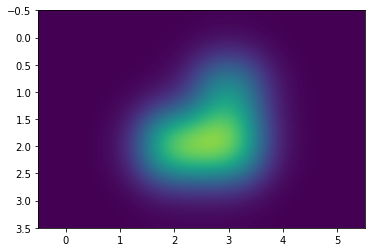

In [12]:
plt.imshow(data, interpolation='gaussian')

In [13]:
#plt.imshow(data2, interpolation='gaussian', alpha=0.5)

# Animation

In [14]:
# def visualize(data, n=100):
#     df = pd.DataFrame(data, columns=['x', 'y', 'value'])
#     grid_x, grid_y = np.mgrid[0:50:complex(0, n), 0:50:complex(0, n)]
#     grid = griddata(df.iloc[:, :2], df.value, xi=(grid_x.flatten(), grid_y.flatten()), method='cubic')
#     grid = np.array(np.array_split(grid, n))
#     ax.clear()
#     ax.imshow(grid, interpolation='gaussian', aspect='equal')
#     ax.axis('off')

In [15]:
%matplotlib notebook

In [16]:
def positions_from_dict(d):
    x = [point[0] for point in positions.values()]
    y = [point[1] for point in positions.values()]
    return x, y

In [17]:
#pd.DataFrame((positions.values()), columns=['x', 'y'])

In [18]:
positions = {'pos1':[1, 10], 'pos2':[2, 20]}
x, y = positions_from_dict(positions)

In [19]:
print(x)
print(y)

[1, 2]
[10, 20]


In [20]:
x = [46, 45, 14, 46, 12, 15, 30, 10, 70, 30, 30, 30, 50, 0]
y = [65, 55, 3, 3, 65, 87, 0, 28, 58, 84, 55, 25, 28, 58]

<IPython.core.display.Javascript object>


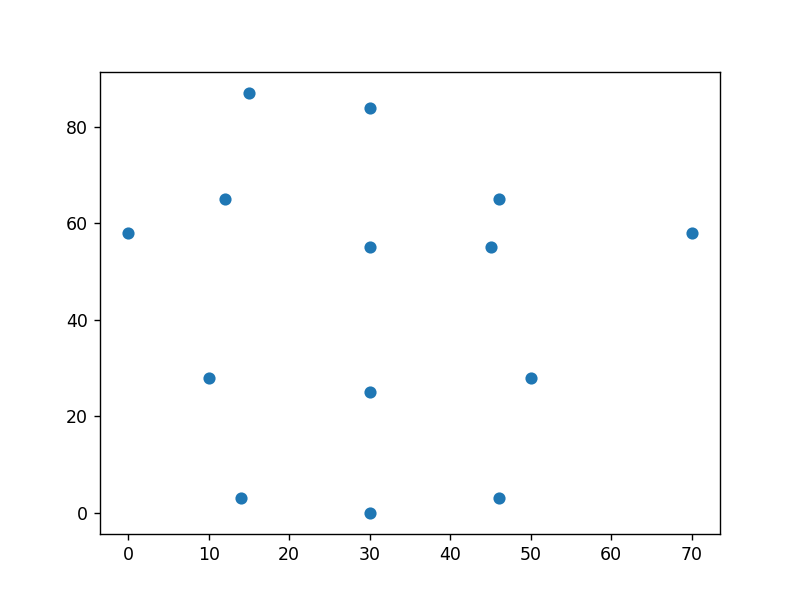

In [22]:
plt.scatter(x, y)
#plt.gca().invert_yaxis()
plt.show()

### Random Values

<IPython.core.display.Javascript object>


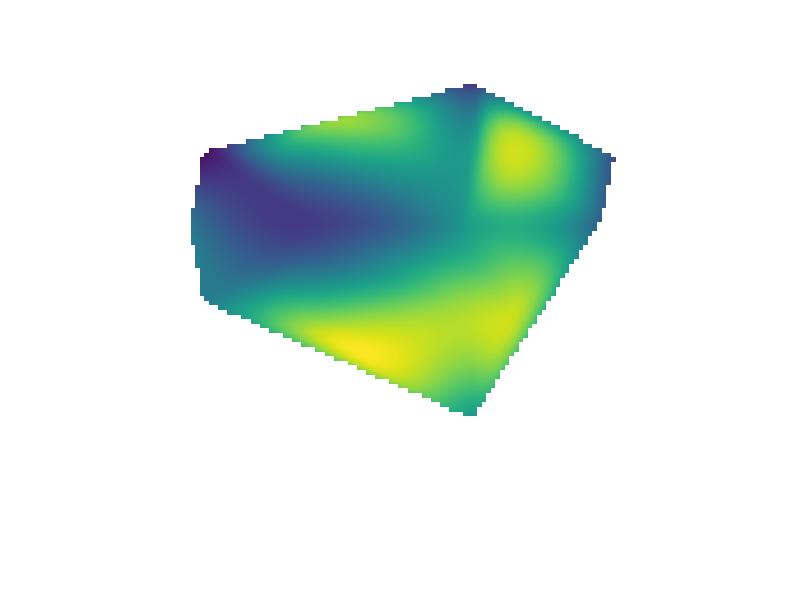

In [27]:
# Create figure for plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# This function is called periodically from FuncAnimation
def animate(i, n=100):
    voc = np.random.randint(0, 100, size=(14))    
    
    grid_x, grid_y = np.mgrid[0:90:complex(0, n), 0:90:complex(0, n)]
    grid = griddata((x, y), voc, xi=(grid_x.flatten(), grid_y.flatten()), method='cubic')
    grid = np.array(np.array_split(grid, n))
    
    ax.clear()
    ax.imshow(grid, interpolation='gaussian', aspect='equal')
    ax.axis('off')

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, interval=500)

### Load File

In [24]:
data = pd.read_csv('voc.csv', header=None)

data = data.iloc[:, 1::2]

for c in data.columns:
    data[c] = data[c].str.replace(']', '')

data = data.astype(float)

print(data.shape)
data.head()

(23, 14)


,1,3,5,7,9,11,13,15,17,19,21,23,25,27
0,203224.0,434348.0,607749.0,404429.0,556610.0,571101.0,516459.0,553634.0,458132.0,681826.0,474543.0,260846.0,407631.0,338386.0
1,206797.0,440639.0,616811.0,410129.0,566944.0,583549.0,527032.0,559142.0,470036.0,685987.0,479947.0,265258.0,412912.0,342626.0
2,211037.0,445923.0,622614.0,412658.0,573232.0,590239.0,534609.0,565235.0,468391.0,702423.0,494374.0,270709.0,422824.0,349189.0
3,213638.0,458446.0,631525.0,418855.0,582173.0,601916.0,541530.0,572433.0,476731.0,706100.0,495100.0,273633.0,427687.0,353325.0
4,214893.0,458760.0,636383.0,420698.0,583691.0,602458.0,541092.0,579318.0,480151.0,711314.0,495100.0,276853.0,431270.0,356009.0


In [25]:
data.loc[len(data)] = np.zeros(14) # so there is something to see

<IPython.core.display.Javascript object>


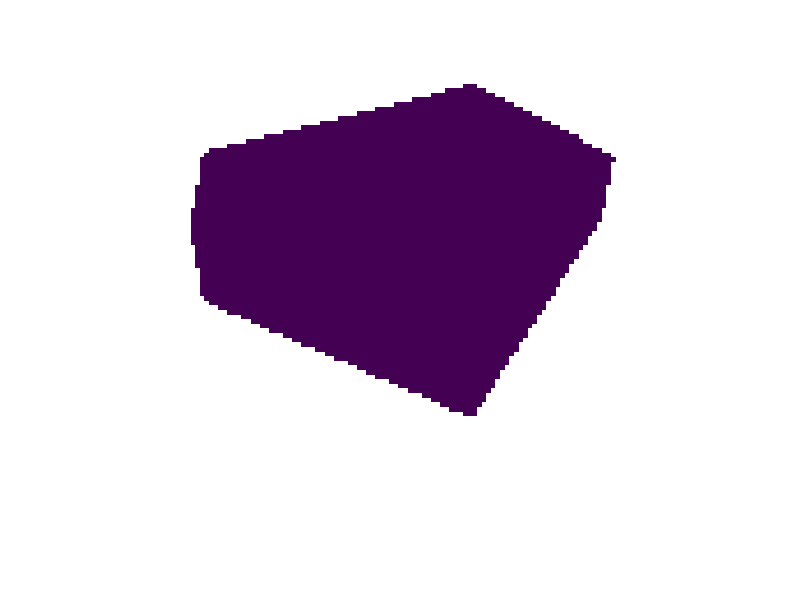

In [26]:
# Create figure for plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

rows = data.iterrows()

# This function is called periodically from FuncAnimation
def animate(i, n=100):
    voc = next(rows)[1].values # TODO: put function here that retrieves new measurements whenever called  
    
    grid_x, grid_y = np.mgrid[0:90:complex(0, n), 0:90:complex(0, n)] # nxn-grid
    grid = griddata((x, y), voc, xi=(grid_x.flatten(), grid_y.flatten()), method='cubic')
    #grid = np.nan_to_num(grid)
    grid = np.array(np.array_split(grid, n))
    
    ax.clear()
    ax.imshow(grid, interpolation='gaussian', aspect='equal')
    ax.axis('off')

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, interval=100)